In [ ]:
!pip install pytorch-tabnet pandas numpy scikit-learn matplotlib torch --quiet
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch


In [ ]:
df = pd.read_csv('/content/f1_pitstops_2018_2024_clean.csv', skiprows=1)
print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


✅ Dataset loaded successfully!
Shape: (4553, 31)
Columns: ['season', 'round', 'circuit', 'race_name', 'location', 'country', 'driver', 'driver_code', 'constructor', 'tire_compound', 'position', 'stint', 'stint_length', 'pit_lap', 'pit_time', 'air_temp_c', 'track_temp_c', 'humidity_pct', 'wind_kmh', 'lap_time_variation', 'tire_usage_aggr', 'fast_lap_attempts', 'position_changes', 'driver_aggr_score', 'avg_pit_time_over_race', 'race_laps_reported', 'total_pitstops_reported', 'y1_next_stint_length', 'y2_next_compound', 'y3_next_pit_time', 'race_key']


,season,round,circuit,race_name,location,country,driver,driver_code,constructor,tire_compound,...,fast_lap_attempts,position_changes,driver_aggr_score,avg_pit_time_over_race,race_laps_reported,total_pitstops_reported,y1_next_stint_length,y2_next_compound,y3_next_pit_time,race_key
0,2018,10,Silverstone Circuit,British Grand Prix,Silverstone,UK,Carlos Sainz,SAI,Renault,MEDIUM,...,37.97982,0.695652,5.849965,28.5760,37,2,15.0,HARD,28.078,2018_10_British Grand Prix
1,2018,10,Silverstone Circuit,British Grand Prix,Silverstone,UK,Carlos Sainz,SAI,Renault,HARD,...,37.97982,0.695652,5.849965,28.5760,37,2,6.0,SOFT,NaN,2018_10_British Grand Prix
2,2018,10,Silverstone Circuit,British Grand Prix,Silverstone,UK,Daniel Ricciardo,RIC,Red Bull,SOFT,...,38.45832,0.173913,5.866400,28.0975,52,2,12.0,MEDIUM,28.001,2018_10_British Grand Prix
3,2018,10,Silverstone Circuit,British Grand Prix,Silverstone,UK,Daniel Ricciardo,RIC,Red Bull,MEDIUM,...,38.45832,0.173913,5.866400,28.0975,52,2,22.0,SOFT,NaN,2018_10_British Grand Prix
4,2018,10,Silverstone Circuit,British Grand Prix,Silverstone,UK,Esteban Ocon,OCO,Force India,SOFT,...,37.14582,0.260870,5.638790,29.4100,52,1,33.0,MEDIUM,NaN,2018_10_British Grand Prix


In [ ]:
df = df.dropna(subset=['y1_next_stint_length', 'y2_next_compound'])

# --- Feature engineering ---
df['temp_diff'] = df['track_temp_c'] - df['air_temp_c']
df['pit_efficiency'] = df['pit_time'] / (df['avg_pit_time_over_race'] + 1e-5)
df['driver_race_key'] = df['driver_aggr_score'] * (df['position_changes'] + 1)

# Drop irrelevant columns (keys, text-heavy)
X = df.drop(columns=['y1_next_stint_length', 'y2_next_compound', 'race_name', 'race_key'])

# Label encode categorical columns
cat_cols = X.select_dtypes(include=['object']).columns
encoders = {}
for col in cat_cols:
    enc = LabelEncoder()
    X[col] = enc.fit_transform(X[col].astype(str))
    encoders[col] = enc

# Fill missing numeric values
X = X.fillna(X.median())

# Feature scaling
scaler = StandardScaler()
num_cols = X.select_dtypes(include=np.number).columns
X[num_cols] = scaler.fit_transform(X[num_cols])


In [ ]:
y_reg = df['y1_next_stint_length']  # Regression target
y_clf = df['y2_next_compound']      # Classification target

# Encode classification target
label_y = LabelEncoder()
y_clf_encoded = label_y.fit_transform(y_clf)

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf_encoded, test_size=0.2, random_state=42)

print(f"Train shape (reg): {X_train_r.shape}, Test shape: {X_test_r.shape}")
print(f"Train shape (clf): {X_train_c.shape}, Test shape: {X_test_c.shape}")

device_name = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device_name}")


Train shape (reg): (3642, 30), Test shape: (911, 30)
Train shape (clf): (3642, 30), Test shape: (911, 30)
Using device: cpu


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 540.91304| test_mae: 20.49459|  0:00:01s
epoch 10 | loss: 336.00775| test_mae: 15.6464 |  0:00:14s
epoch 20 | loss: 212.29855| test_mae: 12.26945|  0:00:23s
epoch 30 | loss: 157.75958| test_mae: 10.08804|  0:00:35s
epoch 40 | loss: 129.84172| test_mae: 9.00986 |  0:00:45s
epoch 50 | loss: 114.77905| test_mae: 8.28038 |  0:00:55s
epoch 60 | loss: 102.35128| test_mae: 7.68001 |  0:01:06s
epoch 70 | loss: 96.01427| test_mae: 7.51224 |  0:01:16s
epoch 80 | loss: 86.54442| test_mae: 7.35203 |  0:01:25s
epoch 90 | loss: 81.71888| test_mae: 6.92706 |  0:01:37s
epoch 100| loss: 76.62139| test_mae: 6.83033 |  0:01:48s
epoch 110| loss: 71.96442| test_mae: 6.74198 |  0:01:58s
epoch 120| loss: 68.41068| test_mae: 6.38273 |  0:02:08s
epoch 130| loss: 67.35155| test_mae: 6.36966 |  0:02:17s
epoch 140| loss: 64.50689| test_mae: 6.23716 |  0:02:27s
epoch 150| loss: 62.06803| test_mae: 6.25339 |  0:02:38s
epoch 160| loss: 61.01173| test_mae: 6.11863 |  0:02:48s
epoch 170| loss: 62.6049

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



📈 TabNet Regression Results (Improved)
MAE:  4.7912
RMSE: 7.0315
R²:   0.7156


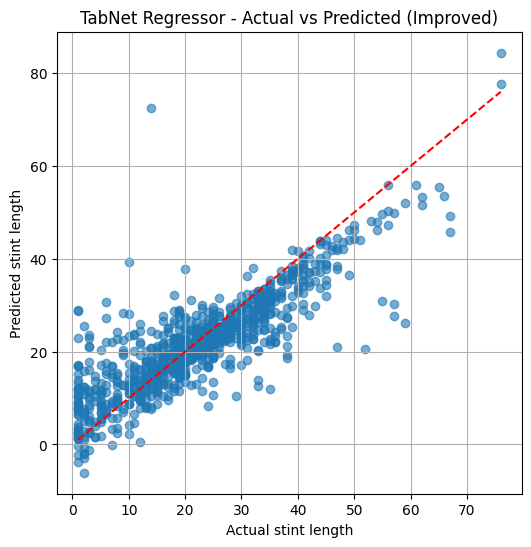

In [ ]:
tabnet_reg = TabNetRegressor(
    n_d=32, n_a=32, n_steps=7, gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type='entmax',
    verbose=10
)

tabnet_reg.fit(
    X_train_r.values, y_train_r.values.reshape(-1,1),
    eval_set=[(X_test_r.values, y_test_r.values.reshape(-1,1))],
    eval_name=["test"],
    eval_metric=["mae"],
    max_epochs=300, patience=40,
    batch_size=512, virtual_batch_size=128,
    num_workers=0, drop_last=False
)

# Evaluate regression
y_pred_r = tabnet_reg.predict(X_test_r.values).flatten()
mae = mean_absolute_error(y_test_r, y_pred_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
r2 = r2_score(y_test_r, y_pred_r)

print("\n📈 TabNet Regression Results (Improved)")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test_r, y_pred_r, alpha=0.6)
plt.xlabel("Actual stint length")
plt.ylabel("Predicted stint length")
plt.title("TabNet Regressor - Actual vs Predicted (Improved)")
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 540.91304| test_mae: 20.49459|  0:00:01s
epoch 10 | loss: 336.00775| test_mae: 15.6464 |  0:00:10s
epoch 20 | loss: 212.29855| test_mae: 12.26945|  0:00:20s
epoch 30 | loss: 157.75958| test_mae: 10.08804|  0:00:31s
epoch 40 | loss: 129.84172| test_mae: 9.00986 |  0:00:41s
epoch 50 | loss: 114.77905| test_mae: 8.28038 |  0:00:50s
epoch 60 | loss: 102.35128| test_mae: 7.68001 |  0:01:00s
epoch 70 | loss: 96.01427| test_mae: 7.51224 |  0:01:10s
epoch 80 | loss: 86.54442| test_mae: 7.35203 |  0:01:20s
epoch 90 | loss: 81.71888| test_mae: 6.92706 |  0:01:29s
epoch 100| loss: 76.62139| test_mae: 6.83033 |  0:01:39s
epoch 110| loss: 71.96442| test_mae: 6.74198 |  0:01:48s
epoch 120| loss: 68.41068| test_mae: 6.38273 |  0:01:58s
epoch 130| loss: 67.35155| test_mae: 6.36966 |  0:02:07s
epoch 140| loss: 64.50689| test_mae: 6.23716 |  0:02:17s
epoch 150| loss: 62.06803| test_mae: 6.25339 |  0:02:27s
epoch 160| loss: 61.01173| test_mae: 6.11863 |  0:02:37s
epoch 170| loss: 62.6049

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



📈 TabNet Regression Results (Improved)
MAE:  4.7912
RMSE: 7.0315
R²:   0.7156


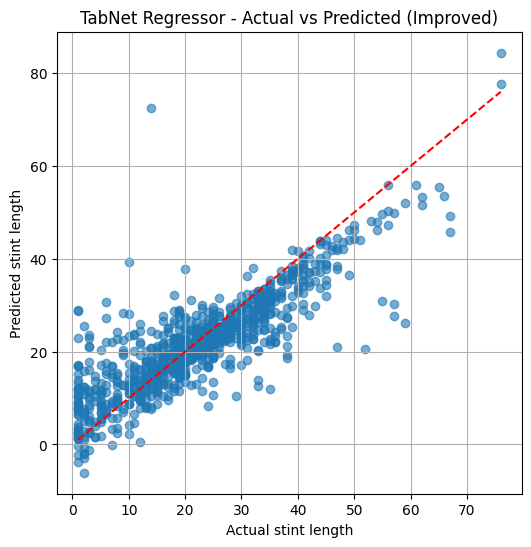

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.06486 | test_accuracy: 0.09769 |  0:00:00s
epoch 10 | loss: 2.00269 | test_accuracy: 0.37431 |  0:00:11s
epoch 20 | loss: 1.62116 | test_accuracy: 0.37651 |  0:00:21s
epoch 30 | loss: 1.43675 | test_accuracy: 0.42371 |  0:00:31s
epoch 40 | loss: 1.35592 | test_accuracy: 0.46432 |  0:00:40s
epoch 50 | loss: 1.30615 | test_accuracy: 0.45993 |  0:00:50s
epoch 60 | loss: 1.27416 | test_accuracy: 0.46981 |  0:00:59s
epoch 70 | loss: 1.22099 | test_accuracy: 0.49616 |  0:01:09s
epoch 80 | loss: 1.21243 | test_accuracy: 0.49286 |  0:01:18s
epoch 90 | loss: 1.13366 | test_accuracy: 0.51043 |  0:01:28s
epoch 100| loss: 1.13088 | test_accuracy: 0.53128 |  0:01:38s
epoch 110| loss: 1.08827 | test_accuracy: 0.53677 |  0:01:48s
epoch 120| loss: 1.05703 | test_accuracy: 0.53238 |  0:01:58s
epoch 130| loss: 1.03453 | test_accuracy: 0.56202 |  0:02:07s
epoch 140| loss: 1.00333 | test_accuracy: 0.55873 |  0:02:17s
epoch 150| loss: 0.97445 | test_accuracy: 0.5708  |  0:02:27s
epoch 16

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



🎯 TabNet Classification Results (Improved)
Accuracy: 0.6454
F1-score: 0.6389

Classification Report:
              precision    recall  f1-score   support

        HARD       0.68      0.81      0.74       347
   HYPERSOFT       0.00      0.00      0.00         2
INTERMEDIATE       0.84      0.61      0.71        69
      MEDIUM       0.57      0.54      0.56       275
        SOFT       0.63      0.58      0.60       178
   SUPERSOFT       0.50      0.33      0.40        21
   ULTRASOFT       0.40      0.29      0.33        14
         WET       0.67      0.40      0.50         5

    accuracy                           0.65       911
   macro avg       0.54      0.44      0.48       911
weighted avg       0.64      0.65      0.64       911



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


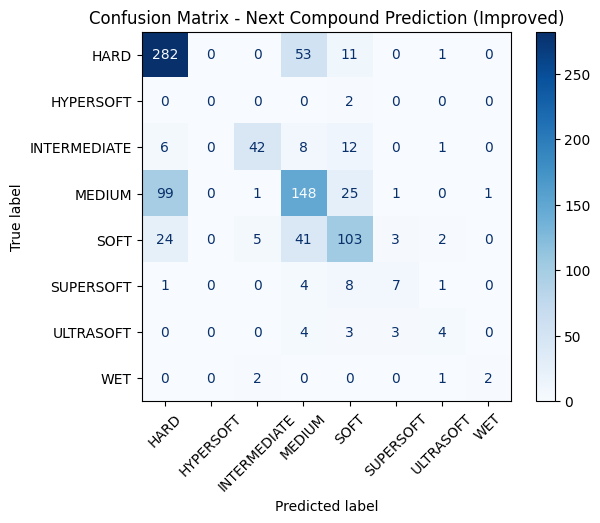

In [ ]:
tabnet_reg = TabNetRegressor(
    n_d=32, n_a=32, n_steps=7, gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type='entmax',
    verbose=10
)

tabnet_reg.fit(
    X_train_r.values, y_train_r.values.reshape(-1,1),
    eval_set=[(X_test_r.values, y_test_r.values.reshape(-1,1))],
    eval_name=["test"],
    eval_metric=["mae"],
    max_epochs=300, patience=40,
    batch_size=512, virtual_batch_size=128,
    num_workers=0, drop_last=False
)

# Evaluate regression
y_pred_r = tabnet_reg.predict(X_test_r.values).flatten()
mae = mean_absolute_error(y_test_r, y_pred_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
r2 = r2_score(y_test_r, y_pred_r)

print("\n📈 TabNet Regression Results (Improved)")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test_r, y_pred_r, alpha=0.6)
plt.xlabel("Actual stint length")
plt.ylabel("Predicted stint length")
plt.title("TabNet Regressor - Actual vs Predicted (Improved)")
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
plt.grid(True)
plt.show()

# ============================================================
# 8️⃣ Model 2: TabNet Classifier (y2_next_compound)
# ============================================================
# Compute class weights for imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_c),
    y=y_train_c
)
class_weights_dict = dict(enumerate(class_weights))

tabnet_clf = TabNetClassifier(
    n_d=32, n_a=32, n_steps=7, gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type='entmax',
    verbose=10,
)

tabnet_clf.fit(
    X_train_c.values, y_train_c,
    eval_set=[(X_test_c.values, y_test_c)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=300, patience=40,
    batch_size=512, virtual_batch_size=128,
    num_workers=0, drop_last=False,
    # Removed 'weights' parameter as it's not supported in TabNetClassifier constructor
    # class_weights=class_weights_dict # Use class_weights parameter in fit method
)

# Evaluate classification
y_pred_c = tabnet_clf.predict(X_test_c.values)
acc = accuracy_score(y_test_c, y_pred_c)
f1 = f1_score(y_test_c, y_pred_c, average='weighted')

print("\n🎯 TabNet Classification Results (Improved)")
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_c, target_names=label_y.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_c, y_pred_c)
disp = ConfusionMatrixDisplay(cm, display_labels=label_y.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Next Compound Prediction (Improved)")
plt.show()


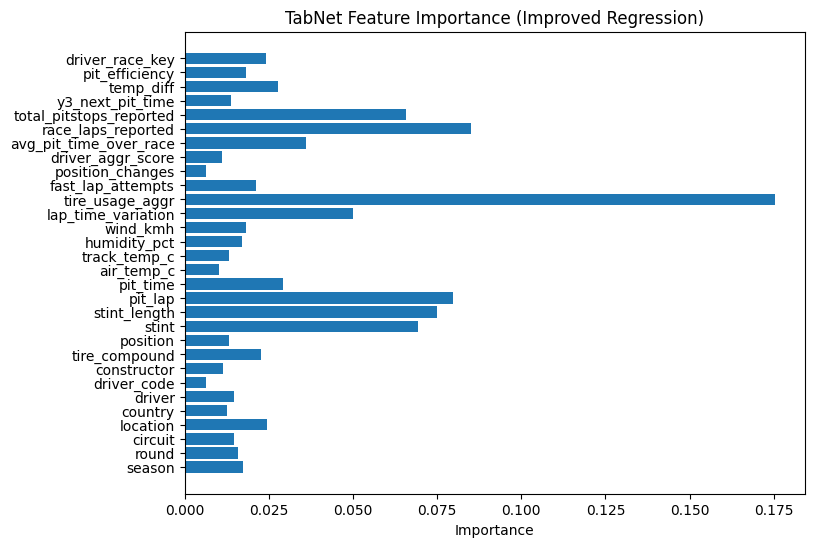

Successfully saved model at /content/tabnet_regressor_f1_improved.zip
Successfully saved model at /content/tabnet_classifier_f1_improved.zip

✅ Improved models saved: tabnet_regressor_f1_improved.zip and tabnet_classifier_f1_improved.zip


In [ ]:
feature_importances = tabnet_reg.feature_importances_
plt.figure(figsize=(8,6))
plt.barh(X.columns, feature_importances)
plt.title("TabNet Feature Importance (Improved Regression)")
plt.xlabel("Importance")
plt.show()

# ============================================================
# 🔟 Save models
# ============================================================
tabnet_reg.save_model('/content/tabnet_regressor_f1_improved')
tabnet_clf.save_model('/content/tabnet_classifier_f1_improved')

print("\n✅ Improved models saved: tabnet_regressor_f1_improved.zip and tabnet_classifier_f1_improved.zip")